In [4]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

 94% 62.0M/66.0M [00:00<00:00, 157MB/s]
100% 66.0M/66.0M [00:00<00:00, 143MB/s]


In [6]:
import zipfile
zip_ref = zipfile.ZipFile('/content/creditcardfraud.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [7]:
import pandas as pd
import numpy as np

# visualisations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context='notebook')
%matplotlib notebook

import gc
gc.enable()

In [8]:
df = pd.read_csv("/content/creditcard.csv")
df.columns = map(str.lower, df.columns)
df.rename(columns={'class': 'label'}, inplace=True)
df.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,label
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
# Turn the amount feature into a normally distributed log equivalent,
# add a negligible amount to avoid taking the log of 0
df['log10_amount'] = np.log10(df.amount + 0.00001)

In [10]:
# keep the label field at the back
df = df[
    [col for col in df if col not in ['label', 'log10_amount']] +
    ['log10_amount', 'label']
]

In [11]:
df.columns

Index(['time', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10',
       'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20',
       'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'amount',
       'log10_amount', 'label'],
      dtype='object')

# Cluster visualization - tSNE

 t-SNE is a dimensionality reduction technique used for visualisations of complex datasets. It maps clusters in high-dimensional data to a two- or three dimensional plane so we can get an idea of how easy it will be to discriminate between classes.

 It does this by trying to keep the distance between data points in lower dimensions proportional to the probability that these data points are neighbours in the higher dimensions.

In [12]:
# manual parameter
RATIO_TO_FRAUD = 15

# dropping redundant columns
df = df.drop(['time', 'amount'], axis=1)

# splitting by class
fraud = df[df.label == 1]
clean = df[df.label == 0]

# undersample clean transactions
clean_undersampled = clean.sample(int(len(fraud) * RATIO_TO_FRAUD),
                                  random_state=42)

# concatenate with fraud transactions into a single dataframe
visualisation_initial = pd.concat([fraud, clean_undersampled])
column_names = list(visualisation_initial.drop('label', axis=1).columns)

# isolate features from labels
features = visualisation_initial.drop('label', axis=1).values
labels = visualisation_initial.label.values

print(f"""The non-fraud dataset has been undersampled from {len(clean):,} to {len(clean_undersampled):,}.
This represents a ratio of {RATIO_TO_FRAUD}:1 to fraud.""")



The non-fraud dataset has been undersampled from 284,315 to 7,380.
This represents a ratio of 15:1 to fraud.


In [13]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

def tsne_scatter(features, labels, dimensions=2, save_as='graph.png'):
    if dimensions not in (2, 3):
        raise ValueError('tsne_scatter can only plot in 2d or 3d (What are you? An alien that can visualise >3d?). Make sure the "dimensions" argument is in (2, 3)')

    # t-SNE dimensionality reduction
    features_embedded = TSNE(n_components=dimensions, random_state=42).fit_transform(features)

    # initialising the plot
    fig, ax = plt.subplots(figsize=(8,8))

    # counting dimensions
    if dimensions == 3: ax = fig.add_subplot(111, projection='3d')

    # plotting data
    ax.scatter(
        *zip(*features_embedded[np.where(labels==1)]),
        marker='o',
        color='r',
        s=2,
        alpha=0.7,
        label='Fraud'
    )
    ax.scatter(
        *zip(*features_embedded[np.where(labels==0)]),
        marker='o',
        color='g',
        s=2,
        alpha=0.3,
        label='Clean'
    )

    # storing it to be displayed later
    plt.legend(loc='best')
    plt.savefig(save_as);
    plt.show()

In [14]:
# tsne_scatter(features, labels, dimensions=2, save_as='tsne_initial_2d.png')

# Train-Test split

Here we don't need target label(y_train,y_validate) as we've already done
### splitting by class
    fraud = df[df.label == 1]
    clean = df[df.label == 0]

but we still need y_test to compare our prediction with actual true label



**Here we train model on clean/non-fraud data, so while testing if the reconstruction error is high that means it's an anomaly i.e fraud**

# Normalize & Standardize

We transform training & validation set during model build,but don't transform the test set because if we do so we've to again use inverse transformation. We can't skew/change the distribution of data during model inference.



In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline

from tqdm import tqdm

In [17]:
# Shuffle the training set
clean = clean.sample(frac=1).reset_index(drop=True)

# Training set: exclusively non-fraud transactions
X_train = clean.iloc[:200000].drop('label', axis=1)

# Train // Validate - no labels since they're all clean anyway
x_train, x_val = train_test_split(X_train, test_size=0.2, random_state=42)

# Testing set: the remaining non-fraud + all the fraud
X_test = clean.iloc[200000:].append(fraud).sample(frac=1)

# Manually splitting the labels from the test df
x_test, y_test = X_test.drop('label', axis=1).values, X_test.label.values

# configure our pipeline
pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])

# get normalization parameters by fitting to the training data
pipeline.fit(X_train);

# transform the training and validation data with these parameters
x_train = pipeline.transform(x_train)
X_val = pipeline.transform(x_val)

# Convert to NumPy arrays first
x_train, x_val, x_test, y_test = map(np.array, (x_train, x_val, x_test, y_test))

# Convert to PyTorch tensors
x_train, x_val, x_test, y_test = map(torch.tensor, (x_train, x_val, x_test, y_test))

print(f"""Shape of the datasets:
    training (rows, cols), datatype = {x_train.shape},{x_train.dtype}
    validate (rows, cols), datatype = {x_val.shape},{x_val.dtype}
    holdout  (rows, cols), datatype = {x_test.shape},{x_test.dtype}""")



<ipython-input-17-577fdf15d3f5>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test = clean.iloc[200000:].append(fraud).sample(frac=1)


Shape of the datasets:
    training (rows, cols), datatype = torch.Size([160000, 29]),torch.float64
    validate (rows, cols), datatype = torch.Size([40000, 29]),torch.float64
    holdout  (rows, cols), datatype = torch.Size([84807, 29]),torch.float64


In [18]:
# g = sns.PairGrid(pd.DataFrame(X_train_transformed,
#                               columns=column_names).iloc[:,:3].sample(600,random_state=42)
#                               )
# plt.subplots_adjust(top=0.9)
# g.fig.suptitle('After:')
# g.map_diag(sns.kdeplot)
# g.map_offdiag(sns.kdeplot)

# AutoEncoder PyTorch

In [20]:
# Create DataLoader for training and validation data
batch_size = 64
train_loader = DataLoader(TensorDataset(x_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(x_val), batch_size=batch_size)


In [21]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()  # Sigmoid activation for output (0-1 range)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [22]:
# Initialize the autoencoder
input_dim = x_train.shape[1]  # Input dimension
encoding_dim = 32  # Dimension of the encoding
autoencoder = Autoencoder(input_dim, encoding_dim)

In [23]:
# Define the loss function (e.g., Mean Squared Error)
criterion = nn.MSELoss()

# Define the optimizer (e.g., Adam)
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Early stopping parameters
patience = 5  # Number of epochs to wait before early stopping
min_val_loss = float('inf')
no_improvement = 0

In [29]:
EPOCHS = 100
device = "cuda" if torch.cuda.is_available() else "cpu"
# Ensure the model and tensors are on the same device (CPU or GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
autoencoder.to(device)
criterion.to(device)

# Define the data type for your input data
input_data_type = torch.float32  # Adjust as needed based on your data

device

device(type='cuda', index=0)

In [30]:




# Training loop
for epoch in tqdm(range(EPOCHS)):
    autoencoder.train()
    train_loss = 0.0
    for data in train_loader:
        inputs = data[0].to(device).to(input_data_type)  # Set the data type of the input tensor
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation loop
    autoencoder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs = data[0].to(device).to(input_data_type)  # Set the data type of the input tensor
            outputs = autoencoder(inputs)
            loss = criterion(outputs, inputs)
            val_loss += loss.item()

    # Calculate average losses
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    # Early stopping check
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        no_improvement = 0
    else:
        no_improvement += 1

    print(f'Epoch [{epoch+1}/100], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Check for early stopping
    if no_improvement >= patience:
        print("Early stopping!")
        break


  1%|          | 1/100 [00:04<07:52,  4.77s/it]

Epoch [1/100], Train Loss: 0.0001, Val Loss: 0.8985


  2%|▏         | 2/100 [00:09<08:08,  4.98s/it]

Epoch [2/100], Train Loss: 0.0001, Val Loss: 0.8991


  3%|▎         | 3/100 [00:14<07:58,  4.93s/it]

Epoch [3/100], Train Loss: 0.0001, Val Loss: 0.8983


  4%|▍         | 4/100 [00:19<07:47,  4.87s/it]

Epoch [4/100], Train Loss: 0.0001, Val Loss: 0.8985


  5%|▌         | 5/100 [00:24<07:53,  4.99s/it]

Epoch [5/100], Train Loss: 0.0001, Val Loss: 0.8988


  6%|▌         | 6/100 [00:29<07:41,  4.91s/it]

Epoch [6/100], Train Loss: 0.0001, Val Loss: 0.9002


  7%|▋         | 7/100 [00:34<07:48,  5.04s/it]

Epoch [7/100], Train Loss: 0.0001, Val Loss: 0.9000


  7%|▋         | 7/100 [00:40<08:52,  5.73s/it]

Epoch [8/100], Train Loss: 0.0001, Val Loss: 0.9014
Early stopping!


In [53]:
# Move 'x_test' to the same device as the model (CPU or GPU)
x_test = x_test.to(device)  # Make sure 'device' is set to CPU or GPU as needed

# Set the model to evaluation mode
autoencoder.eval()

# Perform inference with the model
with torch.no_grad():
    x_test_reconstructed = autoencoder(x_test)

# Calculate the reconstruction error (e.g., mean squared error)
reconstruction_error = torch.mean((x_test - x_test_reconstructed)**2, dim=1).cpu().numpy()

# Define a threshold for anomaly detection (e.g., using percentiles)
threshold = np.percentile(reconstruction_error, 95)  # Adjust the percentile as needed

# Compare the reconstruction error with the threshold
predicted_labels = (reconstruction_error > threshold).astype(int)


In [55]:
# Now you can compare 'predicted_labels' with 'y_test' to identify anomalies
accuracy = np.mean(predicted_labels == y_test.cpu().numpy())
print(f"Accuracy on test set: {accuracy:.4f}")

Accuracy on test set: 0.9541


In [57]:
result_df = pd.DataFrame({"Predicted_label":predicted_labels,"Actual_label":y_test})
result_df.head()

,Predicted_label,Actual_label
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [43]:
# result_df[result_df["Predicted Labels"]!=result_df["Actual Labels"]]

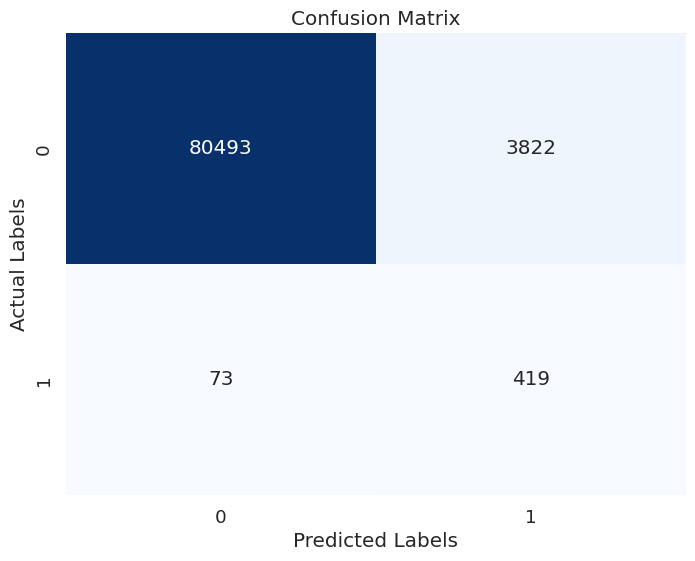

In [58]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming you have 'predicted_labels' and 'y_test' as NumPy arrays

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)

# Define class labels (if you have binary labels, it's usually [0, 1])
class_labels = np.unique(y_test)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()


In [42]:
#